In [1]:
# Import required packages
import matplotlib
matplotlib.use('Agg')
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt; plt.rcdefaults()
import json
import pymongo
from pymongo import MongoClient
import geohash
import pprint
import itertools
from operator import itemgetter
from statistics import mean
import webbrowser
import numpy as np
import gmplot
# To display graphs in Jupyter Notebook
%matplotlib notebook


### 3.A Streaming Data Visualisation

In [2]:
# Function to visualise max point
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max Air Temperature:{},\n Arrival Time={}'.format(ymax, xmax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

In [3]:
# Function to visualise min point
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min Air Temperature:{},\n Arrival Time={}'.format(ymin,xmin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)


In [4]:
# Assign topic name
topic = 'climate_streaming'

# Function to connect kafka
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   # Stop iteration if no recieved message after 10 sec
                                   consumer_timeout_ms=10000, 
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [5]:
def init_plots():
    try:
        # Assign geometry
        width = 9.5
        height = 6
        
        # Create a new figure
        fig2 = plt.figure(figsize=(width,height)) 
        fig2.subplots_adjust(hspace=0.8)
        
        # Add axes to the grid
        ax2 = fig2.add_subplot(111)
        
        # Add label and title names
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Air Temperature')
        ax2.title.set_text('Arrival Time Vs Air Temperature')
        fig2.suptitle('Real-time uniform stream data visualization with interesting points')
        
        # Display figure
        fig2.show() 
        fig2.canvas.draw() 
        return fig2, ax2 
    except Exception as ex:
        print(str(ex))
        

In [6]:
def consume_messages(consumer, fig, ax2):
    try:
        # container for x and y values
        x2, y2 = [], []
        print('Waiting for messages')
        
        # For every recieved message
        for message in consumer:
            
            # Decode
            data = message.value.decode('utf-8')
            
            # Turn into JSON
            data=json.loads(data)
            
            # Get Air tempreture
            air_temp = data['air_temperature_celcius']
            
            # Get Time
            x2.append(dt.datetime.now().strftime("%X"))
            
            # Add Tempreture data to y2 list
            y2.append(air_temp)
            
            # After recieving 5 air tempreture value
            if len(y2) > 5:
                
                # Set figure features and plot
                ax2.clear()
                ax2.plot(x2, y2)
                ax2.set_xlabel('Arrival Time')
                ax2.set_ylabel('Air Temperature')
                ax2.set_title('Arrival Time Vs Air Temperature')
                ax2.set_ylim(0,50) 
                ax2.set_yticks([0,10,20,30,40])
                
                # Show max min points
                annotate_max(x2, y2, ax2)
                annotate_min(x2, y2, ax2)
                
                fig.canvas.draw()
                
                # Remove oldest item
                x2.pop(0) 
                y2.pop(0)
        #plt.close('all')
    except Exception as ex:
        print(str(ex))
    

<IPython.core.display.Javascript object>


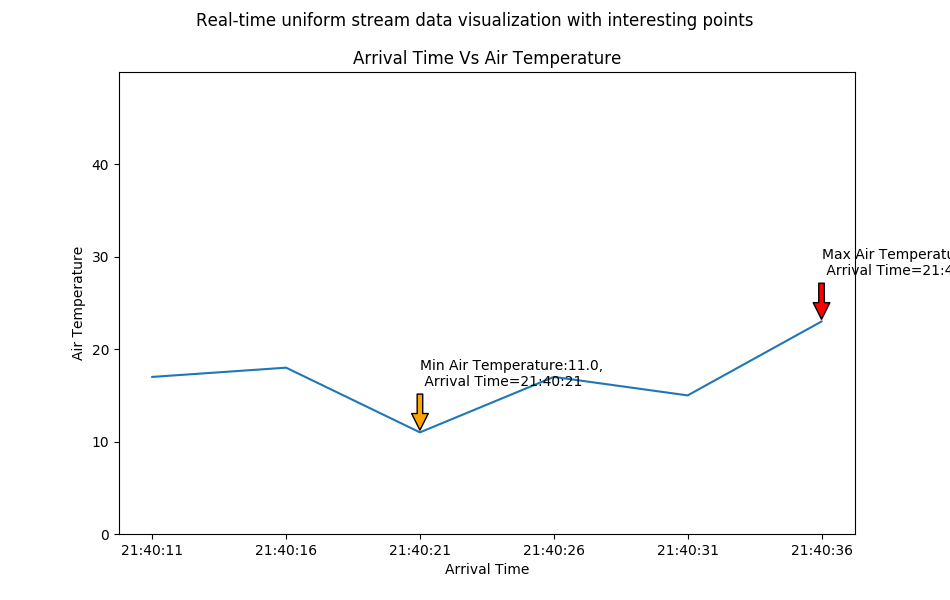

Waiting for messages
Stop visualisation


In [7]:
if __name__ == '__main__':
    try:
        consumer = connect_kafka_consumer()
        fig2, ax2 = init_plots()
        consume_messages(consumer, fig2, ax2)
        
    except KeyboardInterrupt:
        print("Stop visualisation")

### 3.B Static Data Visualisation

##### 1

In [8]:
# Connect to Mongo
client = MongoClient ()
db = client.assignment
collection = db.measurement

In [9]:
def getDatesvalue(d):
    values=list()
    dates=list()
    for doc in d:
        dates.append(doc['_id'])
        values.append(doc['count'])
        
    return dates, values

In [10]:
data=collection.aggregate([{"$unwind":"$hotspot"}, 
                           {'$group':{'_id':"$date", 'count':{'$sum':1}}}, 
                           {'$sort':{"count":-1}}, 
                           {'$limit':10}])


<IPython.core.display.Javascript object>


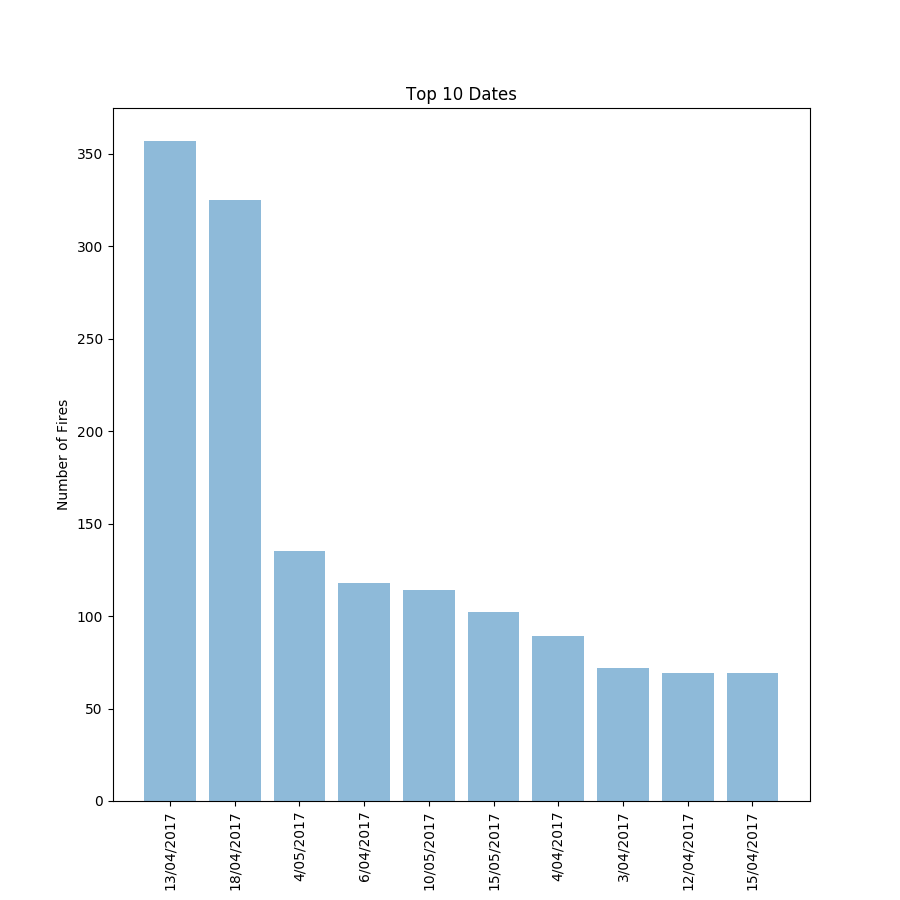

In [11]:
# Querry Top 10 dates with most number of fires
data=collection.aggregate([{"$unwind":"$hotspot"}, 
                           {'$group':{'_id':"$date", 'count':{'$sum':1}}}, 
                           {'$sort':{"count":-1}}, 
                           {'$limit':10}])


# Turn query into list of dates and number of fires
dates , fires = getDatesvalue(data)

# Position of y thicks
y_pos = np.arange(len(dates))

# Determine figure size
fig = plt.figure(figsize=(9, 9))

# Assign features and plot bar chart
plt.bar(y_pos, fires, align='center', alpha=0.5)
plt.xticks(y_pos, dates, rotation='vertical')
plt.ylabel('Number of Fires')
plt.title('Top 10 Dates')

plt.show()


##### 2

In [12]:
# Connect to mongoDB
client = MongoClient()
db = client.assignment
collection = db.measurement

In [13]:
# Latitude and longitude of Melbourne to start with zoom scale 7
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 7) 

In [14]:
def get_geohash(lat, long):  # Bits, nearby places present similar prefixes
    return geohash.encode(lat, long, precision=5) #2.4km error

In [15]:
# Get all the hotspot data with required features
data=collection.aggregate([{"$unwind":"$hotspot"},
                           {'$project':{'latitude':"$hotspot.latitude",'longitude':"$hotspot.longitude",
                                        "surface temp":"$hotspot.surface_temperature_celcius","air temp":"$air_temperature_celcius",
                                        "confidence":"$hotspot.confidence","relative humidity":"$relative_humidity"}}
                          ])


# Append geo_hash value and store all documents in a list
data_ghash=list()
for doc in data:
    doc['geo_hash']=get_geohash(doc['latitude'],doc['longitude'])
    data_ghash.append(doc)

In [16]:
# Sort for easy grouping on geo_hash feature
sorted_data = sorted(data_ghash, key=itemgetter('geo_hash'))

# List to store grouped data
all_groups=list()

# For every geo_hash value and corresponding documents...
for key, group in itertools.groupby(sorted_data, key=lambda x:x['geo_hash']):
    
    
    ##...Turn grouper object into list of dictionaries
    current_group=list(group)
    
    ##... Create lists to store surface temp and confidence of the current group
    temp_list=list()
    conf_list=list()
    
    ###... For every document in group...
    for element in current_group:
        
        ####... Collect all confidence and surface temperature values together
        temp_list.append(element['surface temp'])
        conf_list.append(element['confidence'])
    
    ###... Take the average of confidence and surface temperature
    current_group[0]['surface temp'] = mean(temp_list)
    current_group[0]['confidence'] = mean(conf_list)
    
    ###... Append current group to all groups
    all_groups.append(current_group[0])


In [17]:
# Mark every group on map
for group in all_groups:
    record=dict(group)
    gmap.marker(float(record['latitude']), float(record['longitude']), 'red',title = str('surface temp:'+str(record['surface temp'])
                                                                                         +', air temp:'+str(record['air temp'])
                                                                                        +', relative humidity:'+str(record['relative humidity'])
                                                                                        +', confidence:'+str(record['confidence'])))


In [18]:
# Open web browser and draw the map
gmap.draw("fire spots.html")
webbrowser.open_new("fire spots.html")

True